This notebook is tryting to find mixing time scale using result directly from Paul's model.

Instead of using T = L/u = sqr(S/u2) showed in previous notebook, this notebook will address the time scale using T = S/(U*L) 

but **fisrt, we need to identify L using spatial correlations.**

In [2]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy   as np
import glob
import matplotlib.cm as cm
from scipy import stats
from ArcticTools import map
%matplotlib inline

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
deep= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['deep'][:]
shallow= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['shalow'][:]
nav_lat= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['nav_lat'][:]
nav_lon= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['nav_lon'][:]
e3t= nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc').variables['e3t_0'][0,:]
e1t= nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc').variables['e1t'][0,400:,:]
e2t= nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc').variables['e2t'][0,400:,:]
tmask= nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc').variables['tmask'][0,:,400:,:]

In [4]:
Bathy=nc.Dataset('/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=Bathy.variables['Bathymetry'][400:,:]

In [31]:
def load_velsqu(vel_comp,year,dsfile,layer = 30):
    '''
    This function is designed to obtain (square)velocity field
    '''
    vels ={'usq':'usqure','vsq':'vsqure'}
    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_sqr_vel/EXH005*%s*%s*.nc'%(vel_comp,year))[0]) as velocity:
        data  = velocity.variables[vels[vel_comp]][0,layer,400:,:]
    #data  = np.ma.masked_where(dsfile[layer,...] == 0,data)  # if land is masked, correlations have nan
    data[dsfile[layer,...] == 0] = 0                          # just turn it into 0
    return data

In [41]:
'''Move u2 at just x direction'''

'''allocation'''
num = 10
data1 = np.zeros((2015-2002,e1t.shape[0],e1t.shape[1]));data2 = np.zeros_like(data1);
correlation = np.zeros_like(e1t)

'''load data'''
for year in range (2002,2015):
    data = load_velsqu('usq',year,dsfile=tmask,layer = 30)
    data1[year-2002,num:,:]=data[num:,:]
    data2[year-2002,num:,:]=data[:-num,:]
'''correlation'''
for i in range(data1.shape[1]):
        for j in range(data1.shape[2]):
            correlation[i, j] = np.corrcoef(data1[:,i,j], data2[:,i,j])[0,1]   

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


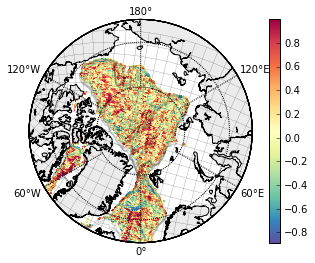

In [45]:
# visualize
m,x_lon,y_lat = map.mapping(65)
m.pcolor(x_lon,y_lat,np.ma.masked_invalid(correlation),cmap='Spectral_r');plt.colorbar()

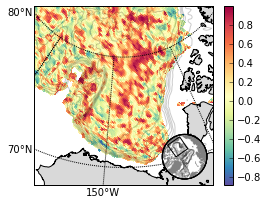

In [49]:
# zoom in cb
f,ax = plt.subplots(1,figsize = (4,4))
m,ax,x_lon,y_lat=map.maponCB(ax)
cs=m.pcolor(x_lon,y_lat,np.ma.masked_invalid(correlation),cmap='Spectral_r')
plt.colorbar(cs,ax=ax, shrink=0.8)

### Explore how does the spatial-lag affects the basin-averaged correlation

In [66]:
def correlation_curve(num,vkey = 'usq',key = 'x'):
    '''num: float, has to > 0
       vkey: velocity key 'usq' or 'vsq' or 'tot'
       key : direction key 'x' or 'y'
    
    '''
    
    
    '''allocation'''
    data1 = np.zeros((2015-2002,e1t.shape[0],e1t.shape[1]));data2 = np.zeros_like(data1);
    correlation = np.zeros_like(e1t)

    '''load data'''
    for year in range (2002,2015):
        if vkey == 'tot':
            data = load_velsqu('usq',year,dsfile=tmask,layer = 30) + load_velsqu('vsq',year,dsfile=tmask,layer = 30)
        else:
            data = load_velsqu(vkey,year,dsfile=tmask,layer = 30)
        if key =='x':
            data1[year-2002,num:,:]=data[num:,:]
            data2[year-2002,num:,:]=data[:-num,:]
        if key =='y':
            data1[year-2002,:,num:]=data[:,num:]
            data2[year-2002,:,num:]=data[:,:-num]
    '''correlation'''
    for i in range(data1.shape[1]):
            for j in range(data1.shape[2]):
                correlation[i, j] = np.corrcoef(data1[:,i,j], data2[:,i,j])[0,1] 
    correlation[deep==0]=np.nan
    return np.nanmean(correlation)

u2 - correlated to itself but slightly moved 5 - 50 grid points away

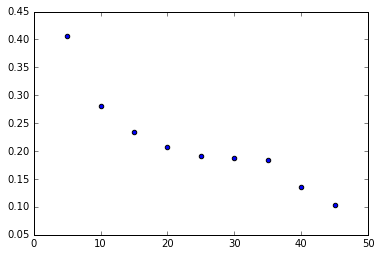

In [57]:
for num in range (5,50,5):
    avgcorr = correlation_curve(num,vkey = 'usq',key = 'x')
    plt.scatter(num,avgcorr)

The plot above suggests L is smaller than 10 grid points. Need to zoom in and decrease the step.

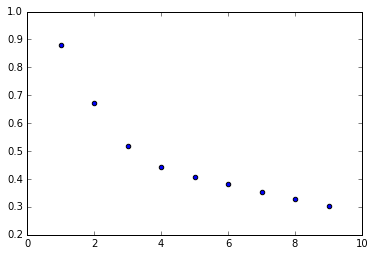

In [61]:
for num in range (1,10):
    avgcorr = correlation_curve(num,vkey = 'usq',key = 'x')
    plt.scatter(num,avgcorr)

The correlation is monotonic decreasing.
Let's try moving the grid in the y direction..

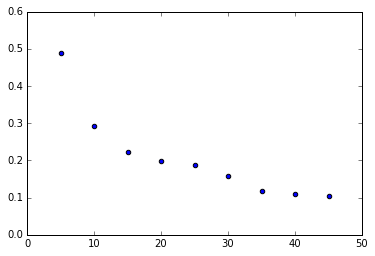

In [60]:
for num in range (5,50,5):
    avgcorr = correlation_curve(num,vkey = 'usq',key = 'y')
    plt.scatter(num,avgcorr)

Similar with that was moved in x-direction. Suggests a zoom in..

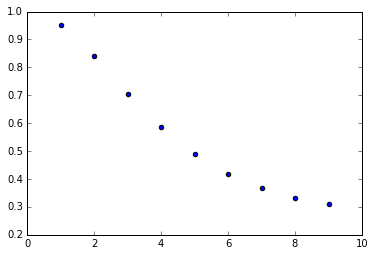

In [63]:
for num in range (1,10):
    avgcorr = correlation_curve(num,vkey = 'usq',key = 'y')
    plt.scatter(num,avgcorr)

For u, the change is monotonic in both y and x direction.. try v

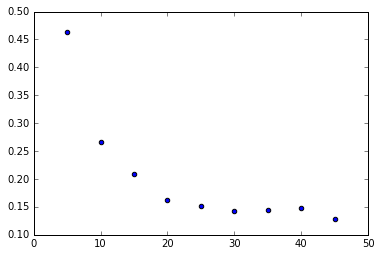

In [64]:
for num in range (5,50,5):
    avgcorr = correlation_curve(num,vkey = 'vsq',key = 'x')
    plt.scatter(num,avgcorr)

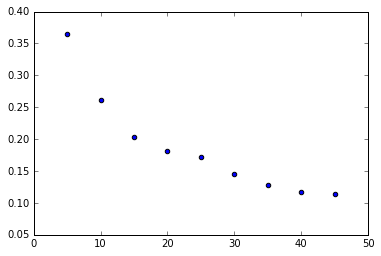

In [65]:
for num in range (5,50,5):
    avgcorr = correlation_curve(num,vkey = 'vsq',key = 'y')
    plt.scatter(num,avgcorr)

 v2: monotonic decreases in both x,y direction. try total: u2+v2.

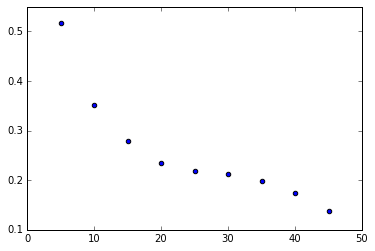

In [67]:
for num in range (5,50,5):
    avgcorr = correlation_curve(num,vkey = 'tot',key = 'x')
    plt.scatter(num,avgcorr)

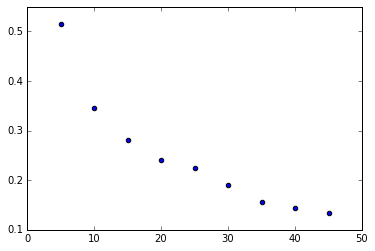

In [68]:
for num in range (5,50,5):
    avgcorr = correlation_curve(num,vkey = 'tot',key = 'y')
    plt.scatter(num,avgcorr)

zoom in 

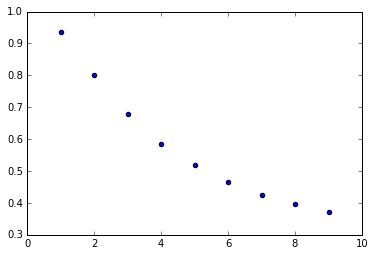

In [69]:
for num in range (1,10,1):
    avgcorr = correlation_curve(num,vkey = 'tot',key = 'x')
    plt.scatter(num,avgcorr)

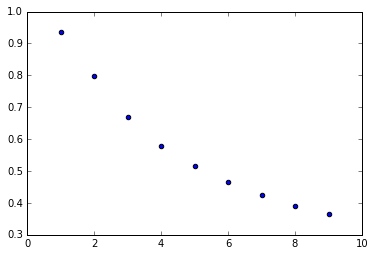

In [70]:
for num in range (1,10,1):
    avgcorr = correlation_curve(num,vkey = 'tot',key = 'y')
    plt.scatter(num,avgcorr)

Perhaps change from basin average to maximum would provide other insigt?